In [159]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib import colors
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import cv2
import os

In [160]:
#name,density,conductivity,capacity,color
materials = [
    ['air',1.2,0.0259,1007,[0.,0.,0.,0.]],
    ['D300',300,0.08,840,'gray'],
    ['sand',1680,0.33,800,'yellow'],
    ['EPPS',100,0.03,1260,'blue'],
    ['mWool',100,0.045,800,'lightgrey'],
    ['copper',8960,395,381,'red']
]

In [161]:
blockdim = 16
dx = 0.01
dt=0.5

MAX_X = 4.2
MAX_Y = 4.2

NX = int(MAX_X/dx/blockdim+1)*blockdim
NY = int(MAX_Y/dx/blockdim+1)*blockdim

MAX_X=NX*dx
MAX_Y=NY*dx

space = np.zeros((NY,NX),dtype=int)

In [162]:
for x in range(0,NX):
    cx = x - NX/2
    for y in range(0,NY):
        cy = y - NY/2
        
        if cx*cx + cy*cy < 3.96/dx/dx:
            space[x,y] = 2
        elif cx*cx + cy*cy < 4/dx/dx:
            space[x,y] = 4
            
for x in range(0,NX,20):
    cx = x - NX/2
    for y in range(0,NY,20):
        cy = y - NY/2
        
        if cx*cx + cy*cy < 1.5/dx/dx:
            space[x,y] = 5

In [163]:
%matplotlib notebook

<IPython.core.display.Javascript object>


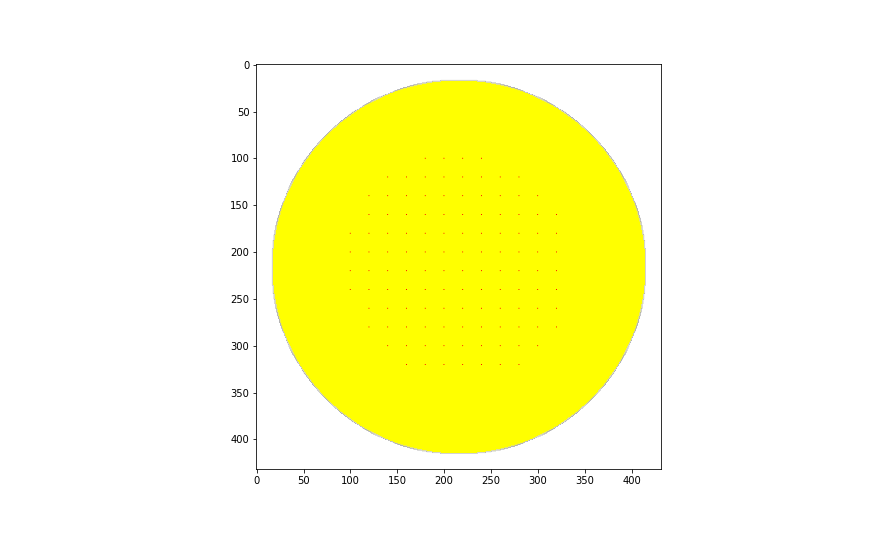

In [164]:
fig = plt.figure()
Space_image = np.zeros((NY,NX,4))

for i in range(1,len(materials)):
    Space_image += (space==i)[:,:,np.newaxis]*colors.to_rgba(materials[i][4])
    

imgplot = plt.imshow(Space_image)

In [175]:
T_min = -15
T_max = 500
T = np.zeros((NY,NX))

W_heat=2000/7

m_copper= materials[5]

dT_heat=W_heat*dt/(m_copper[3]*m_copper[1]*dx*dx*sum(space.ravel() == 5))


def setTempLimits(T):
    T[:,:] = (space==0)*10 + (space!=0)*T
    T[:,:] += (space==5)*dT_heat

def zeroTemp():
    global T
    T[:] = 10
    setTempLimits(T)


zeroTemp()

<IPython.core.display.Javascript object>


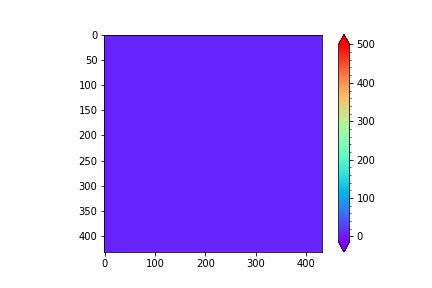

In [176]:
def drawTemp(day=-1):
    global T_min
    global T_max
    
    fig = plt.figure()
    ax = plt.axes()
    
    imgplot = plt.imshow(T,cmap='rainbow',vmin=T_min,vmax=T_max, interpolation='none')
    cbar = fig.colorbar(imgplot, ax=ax, extend='both')
    cbar.minorticks_on()

    if day!=-1:
        plt.text(0, 0, f'day: {day}', horizontalalignment='left',verticalalignment='top',
                fontsize=14,color='white')
        plt.savefig(f'temp{day}.jpg',dpi=270)

    
    plt.show()


drawTemp()

In [177]:
Q = np.zeros((NY,NX))
S = np.zeros((NY,NX))

for i in range(0,len(materials)):
    m = materials[i]
    q = m[1]*m[3]*dx**2
    s = dt*m[2]
    print(f'material={m[0]} q={q}J s={s}J s/q={s/q}')
    Q= (space==i)*q + (space!=i)*Q
    S= (space==i)*s + (space!=i)*S
    
Qc = Q[1:-1,1:-1]

Sc = S[1:-1,1:-1]
Sl = S[1:-1,0:-2]
Sr = S[1:-1,2:]
Su = S[0:-2,1:-1]
Sd = S[2:,1:-1]

Kl = np.ones((NY,NX))
Kr = np.ones((NY,NX))
Ku = np.ones((NY,NX))
Kd = np.ones((NY,NX))

Kl[1:-1,1:-1] = (Sl+Sc)/2/Qc
Kr[1:-1,1:-1] = (Sr+Sc)/2/Qc
Ku[1:-1,1:-1] = (Su+Sc)/2/Qc
Kd[1:-1,1:-1] = (Sd+Sc)/2/Qc

T2 = T.copy();

material=air q=0.12083999999999999J s=0.01295J s/q=0.10716650115855678
material=D300 q=25.200000000000003J s=0.04J s/q=0.001587301587301587
material=sand q=134.4J s=0.165J s/q=0.0012276785714285714
material=EPPS q=12.600000000000001J s=0.015J s/q=0.0011904761904761904
material=mWool q=8.0J s=0.0225J s/q=0.0028125
material=copper q=341.37600000000003J s=197.5J s/q=0.5785409636295462


In [178]:
space_gpu = cuda.to_device(space)
Kl_gpu = cuda.to_device(Kl)
Kr_gpu = cuda.to_device(Kr)
Ku_gpu = cuda.to_device(Ku)
Kd_gpu = cuda.to_device(Kd)
T2_gpu = cuda.to_device(T2)

mod = SourceModule("""
    __global__ void stp(int* space, double* Kl,double* Kr,double* Ku,double* Kd,
        double* T, double* Tn)
    {
        int i = blockDim.x * blockIdx.x + threadIdx.x;
        int j = blockDim.y * blockIdx.y + threadIdx.y;
        const int width=""" +str(NX) + """;
        const double dT_heat=""" +str(dT_heat) + """;
        int ci = i*width+j;

        int li=ci-1;
        int ri=ci+1;
        int ui=ci-width;
        int di=ci+width;
        
        if(space[ci] == 0)
        {
            T[ci]=10;
        }
        else
        {
            T[ci]= Tn[ci] +
                Kl[ci]*(Tn[li]-Tn[ci])+
                Kr[ci]*(Tn[ri]-Tn[ci])+
                Ku[ci]*(Tn[ui]-Tn[ci])+
                Kd[ci]*(Tn[di]-Tn[ci]);
                
            if(space[ci] == 5)
                T[ci]+=dT_heat;                
        }
    }""")

def tempRound():
    global space_gpu
    global Kl_gpu
    global Kr_gpu
    global Ku_gpu
    global Kd_gpu
    global T
    global Tn_gpu
    global mod
    
    t=60*60*24*1
    nt = int(t/dt/2)
    
    T_gpu = cuda.to_device(T)

    func = mod.get_function("stp")
    for i in range(0, nt):
        func(space_gpu, Kl_gpu, Kr_gpu, Ku_gpu, Kd_gpu,T2_gpu,T_gpu,
             block=(blockdim,blockdim,1),grid=(int(NX/blockdim),int(NY/blockdim),1))
        func(space_gpu, Kl_gpu, Kr_gpu, Ku_gpu, Kd_gpu,T_gpu,T2_gpu,
             block=(blockdim,blockdim,1),grid=(int(NX/blockdim),int(NY/blockdim),1))

    T = cuda.from_device_like(T_gpu, T)



C:\Users\Eugene\AppData\Local\Temp\ipykernel_21596\3776028245.py:8: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  mod = SourceModule("""


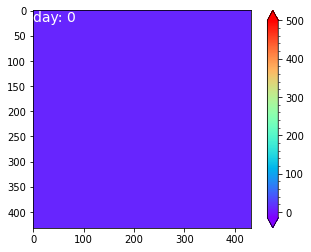

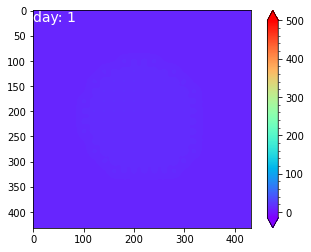

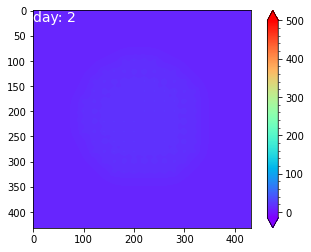

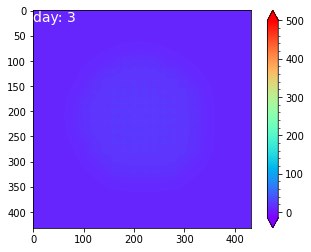

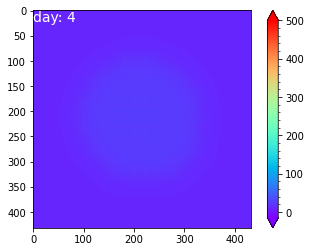

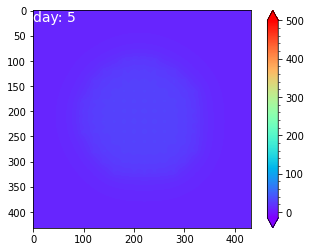

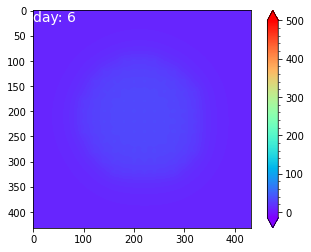

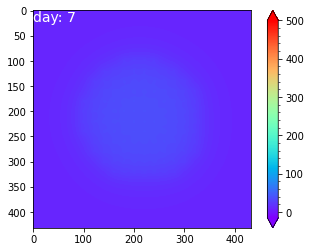

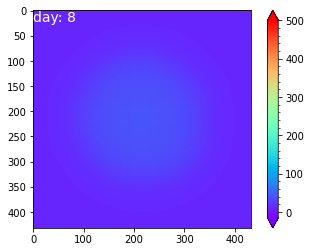

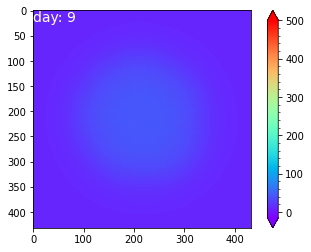

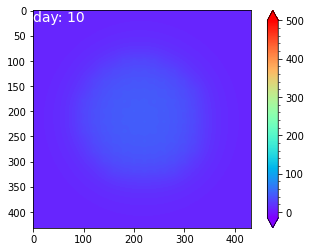

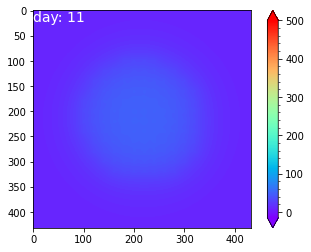

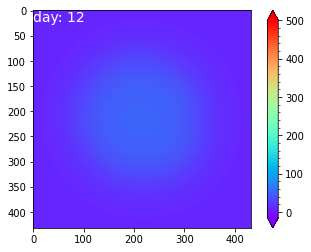

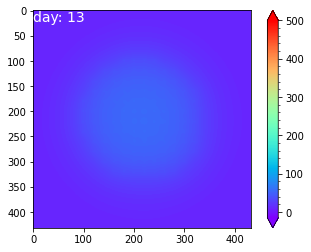

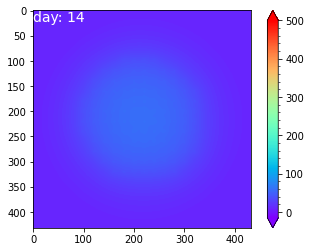

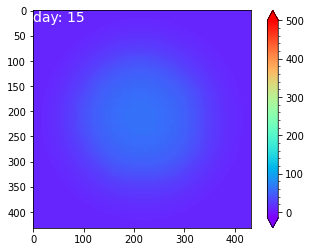

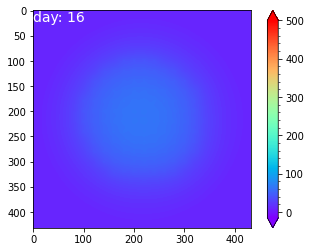

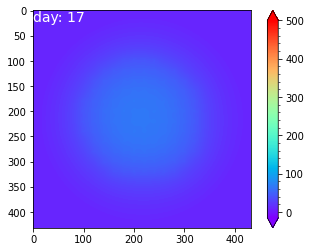

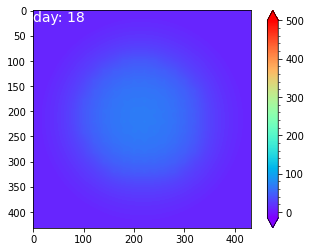

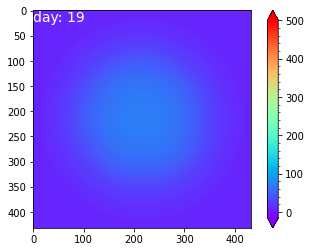

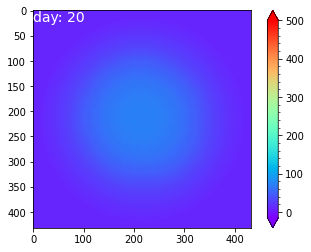

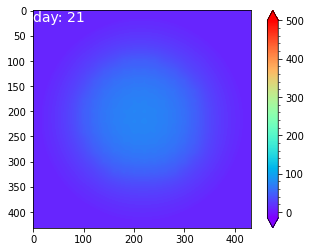

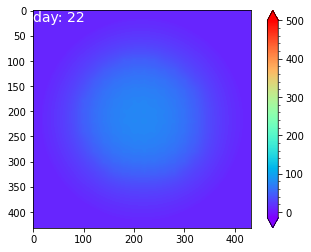

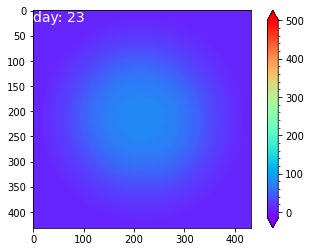

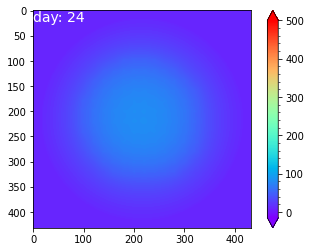

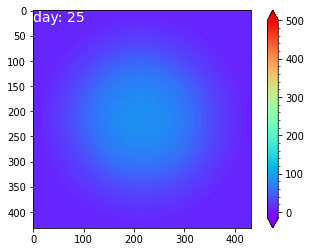

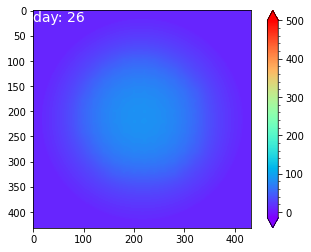

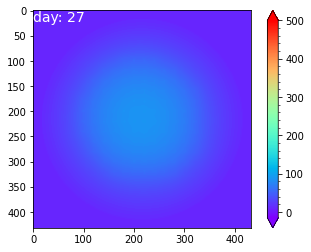

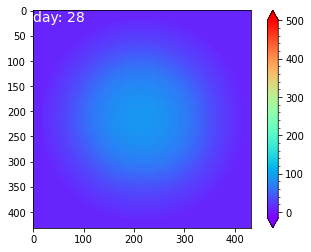

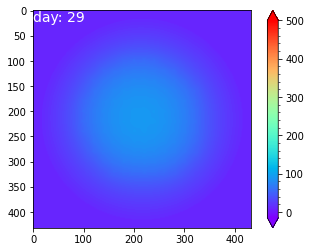

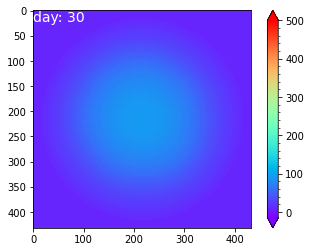

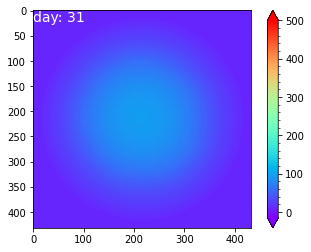

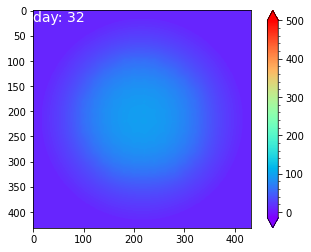

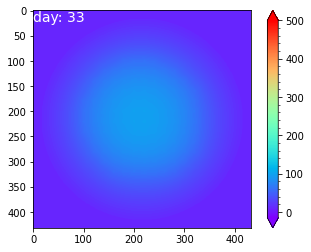

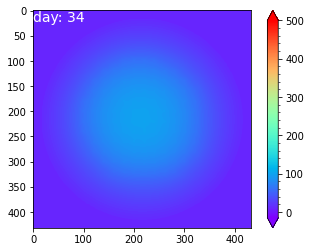

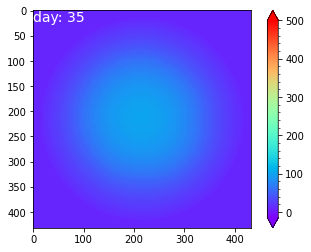

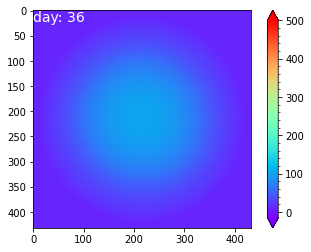

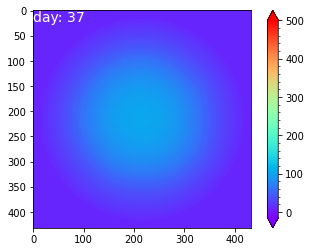

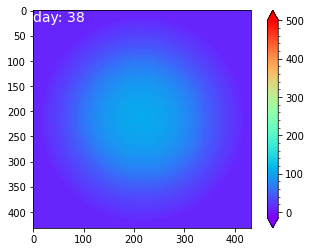

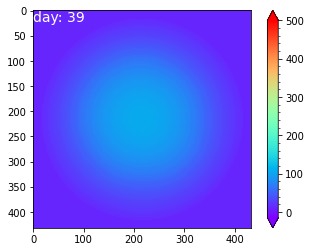

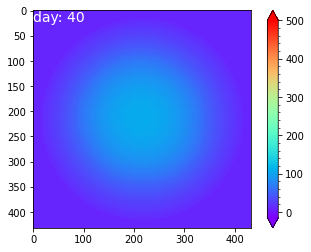

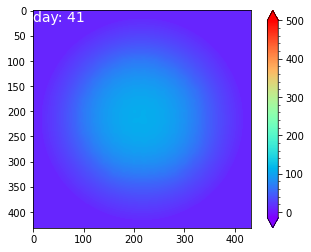

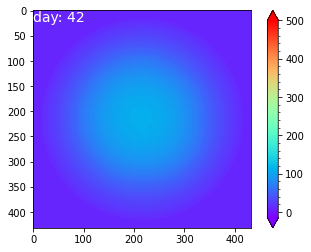

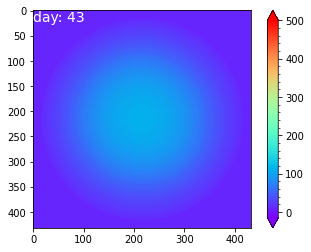

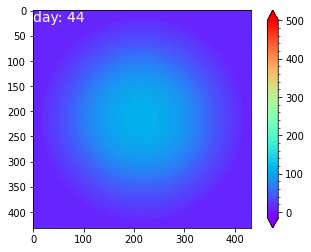

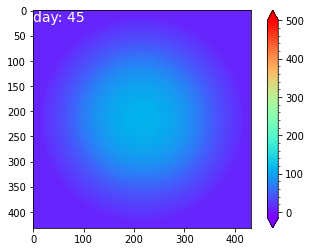

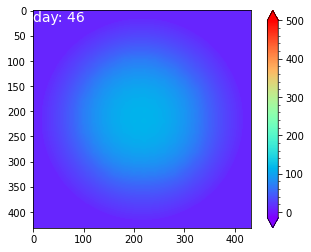

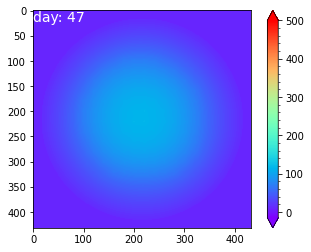

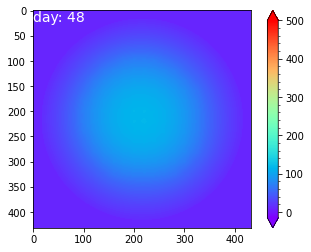

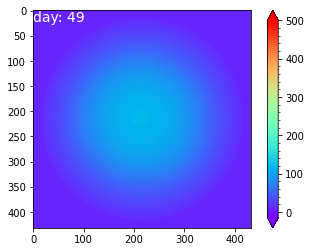

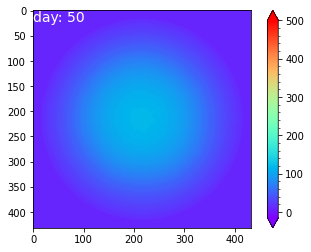

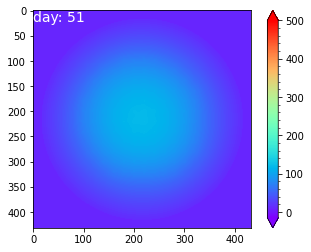

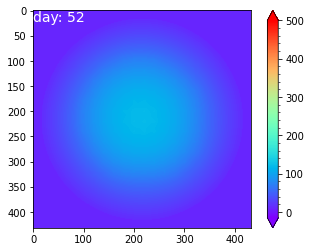

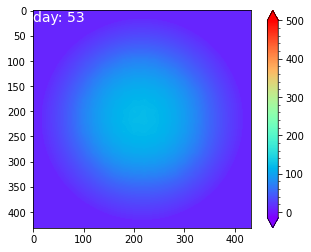

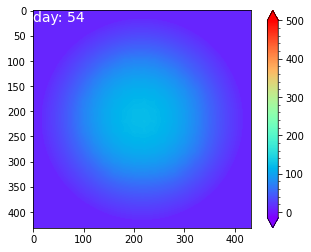

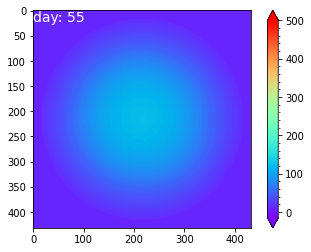

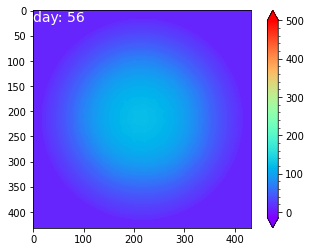

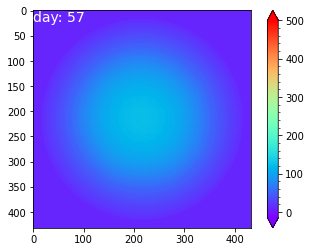

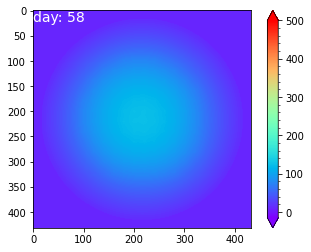

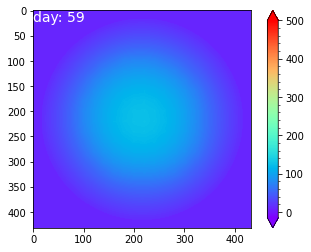

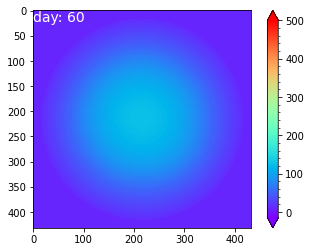

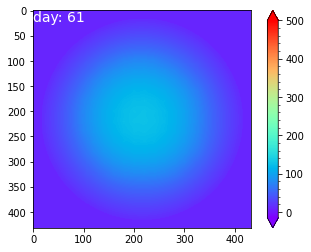

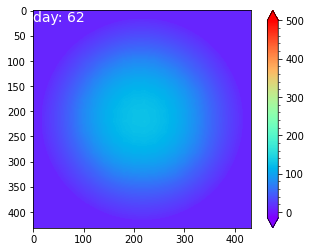

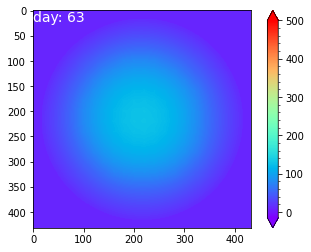

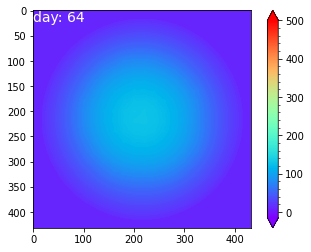

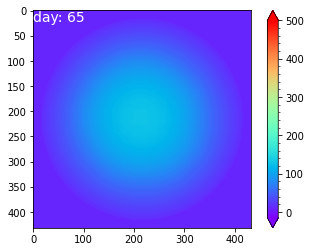

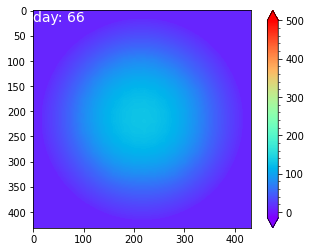

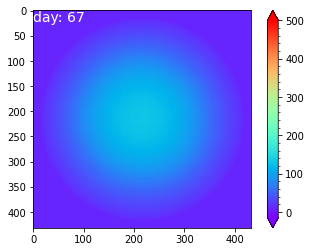

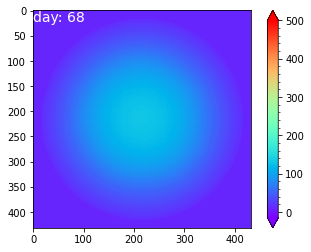

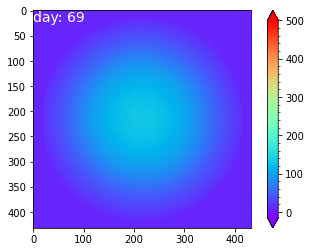

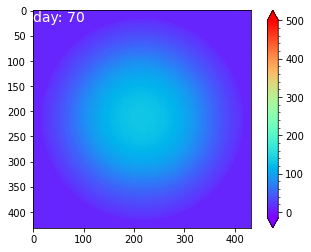

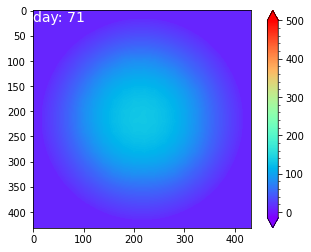

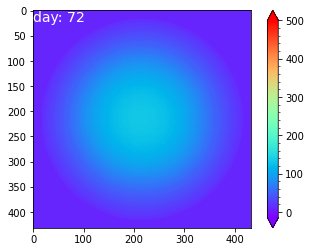

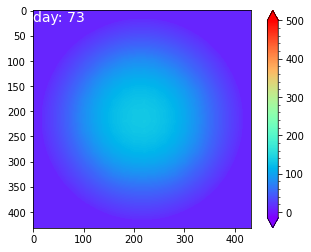

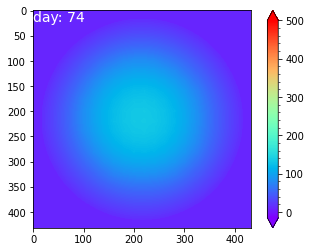

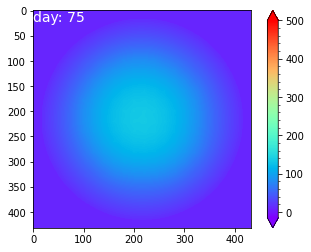

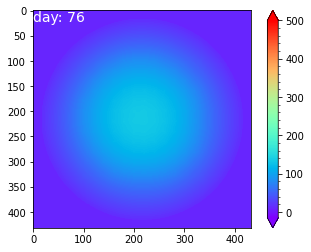

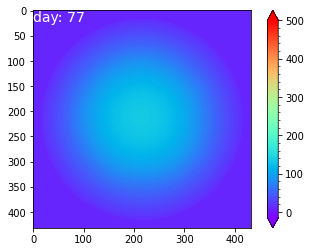

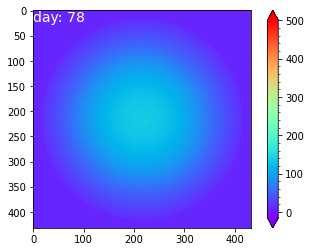

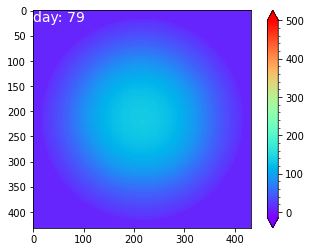

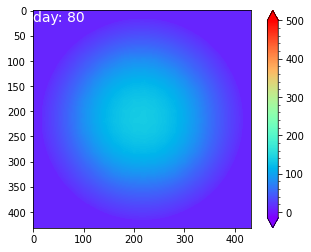

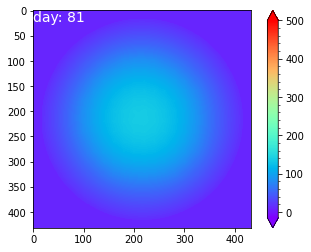

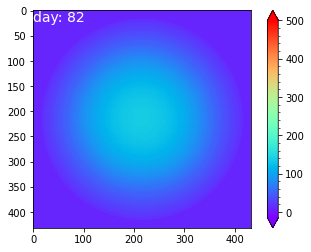

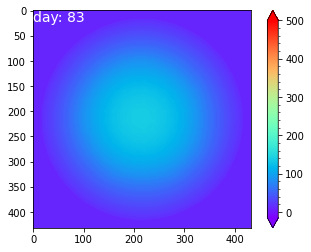

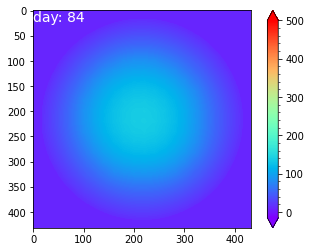

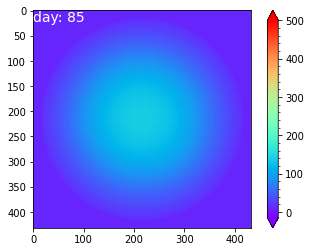

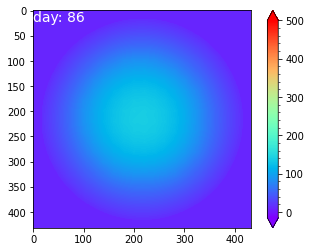

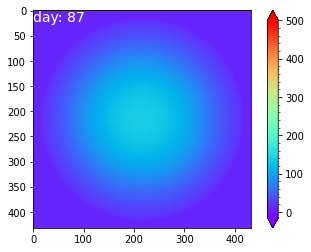

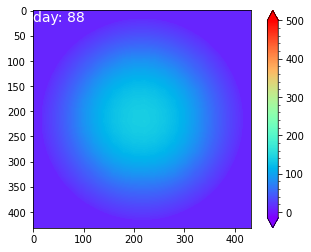

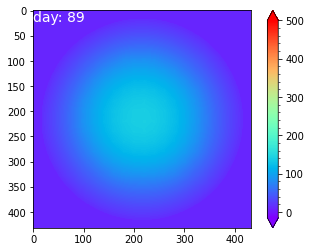

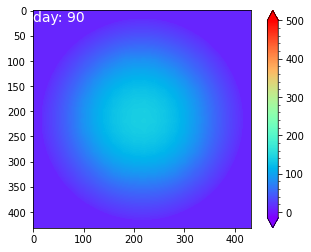

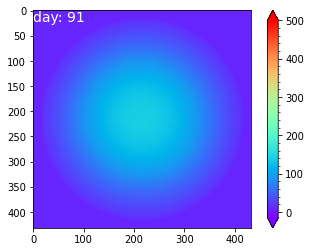

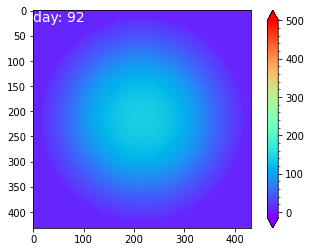

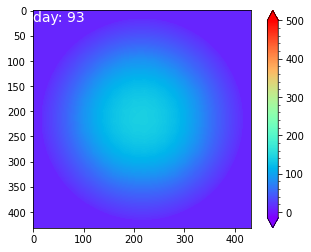

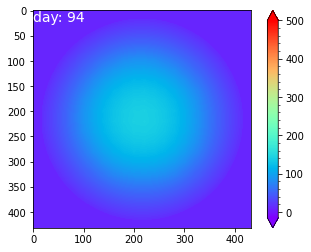

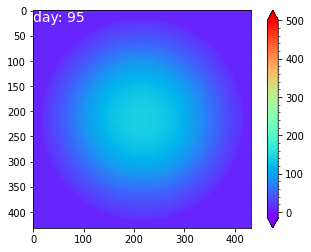

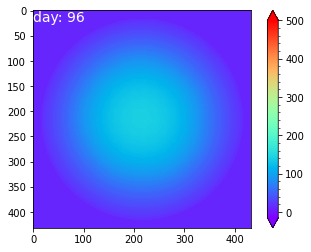

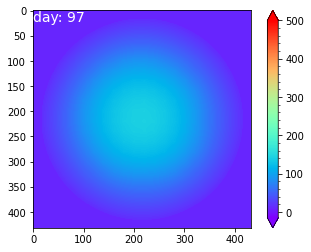

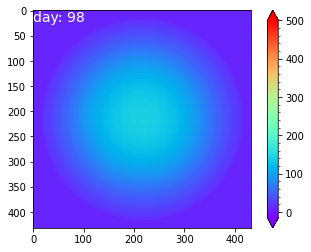

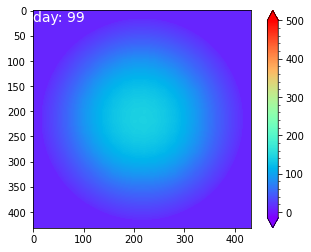

In [179]:
%matplotlib inline
for i in range(0,100):
    if i!=0:
        tempRound()
    drawTemp(i)


<IPython.core.display.Javascript object>


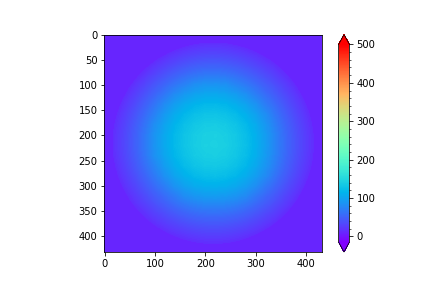

In [180]:
%matplotlib notebook
drawTemp()

In [182]:
frame = cv2.imread('temp0.jpg')
height, width, layers = frame.shape

video = cv2.VideoWriter('temp.avi', 0, 4, (width,height))

for i in range(0,100):
    im = cv2.imread(f'temp{i}.jpg')
    video.write(im)

cv2.destroyAllWindows()
video.release()